# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before

2. Analyze molecules, QMC versus DFT \
    a. Analysis DMC values, timestep dependence \
    b. Comparison with DFT and CCSD(T) (writes *results_mol_dft.pkl*, which also includes CCSD(T) results, and in *delta_mol_ref.pkl* the delta energy with respect to the refence molecule) \
    c. Inference of the VAR per atom from molecules

3. Analyze dimers binding energies \
    a. Do extrapolations w/ w/o Jopt on molecules \
    b. Define gold, silver, bronze schemes, and their cost

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper

---

## Specific tasks here:

Copy data into \
    **data[mol][method][mol_id]**, \
where method is either the DFT functional or the DMC timestep (with err_{timestep} reporting the error). 
For DMC, consider only use **DMCdla5 Jopt**, and **mol_info[mol]['test']** is True. 
Notice that **data[mol]** can be converted in a **pd.DataFrame** with mol_id as index and method as columns.  

Comparison with **HF**, **DFT** (LDA, PBE, B3LYP) and **CCSD(T) cc-pV(D,T)Z** (orca)

Write in a file the delta energy for each structure (mol_id) of each molecule \
    **delta_mol_ref[mol][mol_id] = E[mol_id] - E[ref_mol_id]** \
where E is the energy at the B3LYP level, 
such that in a molecule where only one DMC evaluation was performed, in the **ref_mol_id** structure,
we can estimate \
    **Edmc[mol][mol_id] ~ Edmc[mol][ref_mol_id] + delta_mol_ref[mol][mol_id]**



In [1]:
import os
import re
import math
import pickle 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from def_colors import map_DMC, dmc_color, dft_color

from define_setup import *

# Read mol_info
with open( 'mol_info.pkl', 'rb' ) as f:
    mol_info = pickle.load( f )
#mol_info

df_mol_info = pd.read_csv( 'mol_info.csv', index_col=0 )
df_mol_info

# Read results monomer
import pickle
with open( dir_analysis+'results_mol.pkl', 'rb' ) as f:
    results_mol = pickle.load( f )

In [2]:
df_mol_info

,ref,test,name,formula,atoms,Nel,Nelv
mol,,,,,,,
AcNH2,21_1,True,acetamide,H3C-CO-NH2,"{'H': 5, 'C': 2, 'N': 1, 'O': 1}",32,24
AcOH,20_1,True,acetic acid,H3C-COOH,"{'H': 4, 'C': 2, 'N': 0, 'O': 2}",32,24
Benzene,24_1,False,benzene,C6H6,"{'H': 6, 'C': 6, 'N': 0, 'O': 0}",42,30
Cyclopentane,37_1,True,cyclopentane,(CH2)5,"{'H': 10, 'C': 5, 'N': 0, 'O': 0}",40,30
Ethene,30_2,False,ethene,H2C=CH2,"{'H': 4, 'C': 2, 'N': 0, 'O': 0}",16,12
Ethyne,32_2,False,ethyne,HC---CH,"{'H': 2, 'C': 2, 'N': 0, 'O': 0}",14,10
MeNH2,56_2,False,methylamine,H3C-NH2,"{'H': 5, 'C': 1, 'N': 1, 'O': 0}",18,14
MeOH,55_2,False,methanol,H3C-OH,"{'H': 4, 'C': 1, 'N': 0, 'O': 1}",18,14
Neopentane,36_1,False,neopentane,C(CH3)4,"{'H': 12, 'C': 5, 'N': 0, 'O': 0}",42,32


In [3]:
list_clean = []

for mol in results_mol:
    #print(mol)
    for mol_id in results_mol[mol]:
        #print(mol_id)
        #for dmc_type in results_mol[mol][mol_id]:
            #print(dmc_type)
        if len(results_mol[mol][mol_id].keys())==0:
            print(mol,mol_id)
            list_clean.append( [mol,mol_id] )

#print(list_clean)
for l in list_clean:
    print(l)
    del results_mol[l[0]][l[1]]

Benzene 24_2
Pyridine 25_2
['Benzene', '24_2']
['Pyridine', '25_2']


In [4]:
d = {}
for mol in results_mol.keys():
    #print(mol,mol_info[mol])
    mol_id = mol_info[mol]['ref']
    m = mol_info[mol]['atoms']
    d[mol] = { 
        1 : m['H'],
        6 : m['C'],
        7 : m['N'],
        8 : m['O'],
        'VAR' : results_mol[mol][mol_id]['DMCdla5']['Jopt']['0.01']['Var[au]']
    }

df_var = pd.DataFrame( d ).transpose()
df_var

,1,6,7,8,VAR
AcNH2,5.0,2.0,1.0,1.0,0.606618
AcOH,4.0,2.0,0.0,2.0,0.768151
Benzene,6.0,6.0,0.0,0.0,0.504031
Cyclopentane,10.0,5.0,0.0,0.0,0.455853
Ethene,4.0,2.0,0.0,0.0,0.162709
Ethyne,2.0,2.0,0.0,0.0,0.145566
MeNH2,5.0,1.0,1.0,0.0,0.244109
MeOH,4.0,1.0,0.0,1.0,0.384346
Neopentane,12.0,5.0,0.0,0.0,0.459974
Pentane,12.0,5.0,0.0,0.0,0.457679


In [5]:
from scipy.optimize import curve_fit

y = df_var['VAR'].to_numpy()
X = [ df_var[i].to_numpy() for i in [1,6,7,8]]

def func(X, aH, aC, aN, aO ):
    x1, x6, x7, x8 = X
    return aH*x1 + aC*x6 + aN*x7 + aO*x8 

popt, pcov = curve_fit( func, xdata=X, ydata=y )
print(popt)
print(pcov)


print()
print( f'VAR [H,C,N,O] = {popt}\n' )
Nelv = np.array([1,4,5,6])
print( 'VAR/Nelv [H,C,N,O] =', popt/Nelv )

yhat = func(X, *popt)
yhat

df_var['fit'] = yhat

residual = (y-yhat)
SSR = residual.transpose().dot(residual)
print('SSR =',SSR)

[0.00218076 0.08495009 0.16139633 0.28785168]
[[ 4.55027851e-06 -7.92851528e-06  4.02631116e-06 -3.01283623e-06]
 [-7.92851528e-06  1.68865885e-05 -1.31590454e-05  3.71376285e-06]
 [ 4.02631116e-06 -1.31590454e-05  9.69439321e-05 -4.01412779e-05]
 [-3.01283623e-06  3.71376285e-06 -4.01412779e-05  5.68256319e-05]]

VAR [H,C,N,O] = [0.00218076 0.08495009 0.16139633 0.28785168]

VAR/Nelv [H,C,N,O] = [0.00218076 0.02123752 0.03227927 0.04797528]
SSR = 0.004054712302787066


0.08998503045651435 1.3127654633936656


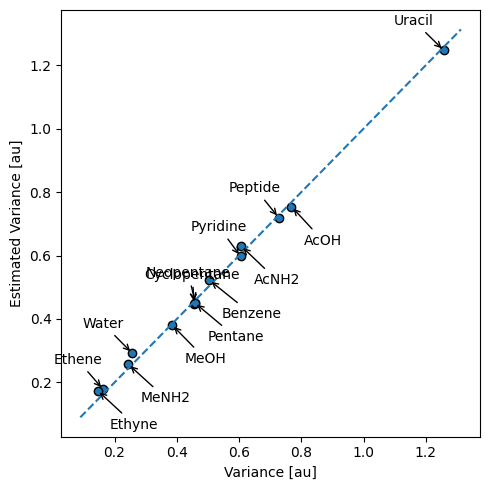

In [6]:
fig, ax = plt.subplots( figsize=(5,5) )
ax.scatter(y,yhat,edgecolors='k')
ax.set_xlabel('Variance [au]')
ax.set_ylabel('Estimated Variance [au]')

xmin, xmax = plt.xlim()
print(xmin,xmax)
xv = np.linspace(xmin,xmax,10)
ax.plot(xv,xv,'--')

df = df_var.sort_values('VAR')
n = list( df.index )
xn = list( df.VAR )
yn = list( df.fit )
for i in range(len(xn)):
    ax.annotate(n[i],(xn[i],yn[i]),
                xytext=(xn[i]-(i%2-0.2)*0.2,yn[i]+(i%2-0.6)*0.2),
                arrowprops=dict(facecolor='black', arrowstyle="->"))
#df
fig.tight_layout()
fig.savefig(f'FIG02c/Evaluation_Variance_fit.png',format='png',dpi=300)

Average VAR per valence electron =  0.021243694252167968
VAR/Nelv [H,C,N,O] = [0.00218076 0.02123752 0.03227927 0.04797528]
                 1    6    7    8       VAR       fit  Nelv  fit_Nelv
AcNH2          5.0  2.0  1.0  1.0  0.606618  0.630052  24.0  0.509849
AcOH           4.0  2.0  0.0  2.0  0.768151  0.754327  24.0  0.509849
Benzene        6.0  6.0  0.0  0.0  0.504031  0.522785  30.0  0.637311
Cyclopentane  10.0  5.0  0.0  0.0  0.455853  0.446558  30.0  0.637311
Ethene         4.0  2.0  0.0  0.0  0.162709  0.178623  12.0  0.254924
Ethyne         2.0  2.0  0.0  0.0  0.145566  0.174262  10.0  0.212437
MeNH2          5.0  1.0  1.0  0.0  0.244109  0.257250  14.0  0.297412
MeOH           4.0  1.0  0.0  1.0  0.384346  0.381525  14.0  0.297412
Neopentane    12.0  5.0  0.0  0.0  0.459974  0.450920  32.0  0.679798
Pentane       12.0  5.0  0.0  0.0  0.457679  0.450920  32.0  0.679798
Peptide        7.0  3.0  1.0  1.0  0.727437  0.719364  30.0  0.637311
Pyridine       5.0  5.0  1.0  0.0  0

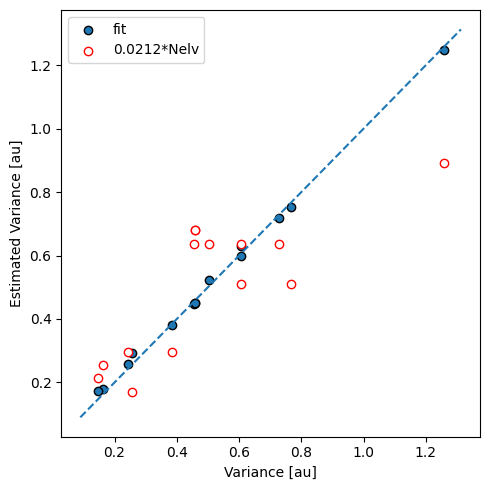

In [7]:
# Naive estimation using number of electrons

df_var['Nelv'] = df_var[1] + 4*df_var[6] + 5*df_var[7] + 6*df_var[8]
aus = df_var['VAR'] / df_var['Nelv']
VAR_per_el = aus.mean()
print('Average VAR per valence electron = ',VAR_per_el)
print( 'VAR/Nelv [H,C,N,O] =', popt/Nelv )

df_var['fit_Nelv'] = VAR_per_el * df_var['Nelv']
print(df_var)

### figure
fig, ax = plt.subplots( figsize=(5,5) )
ax.set_xlabel('Variance [au]')
ax.set_ylabel('Estimated Variance [au]')

y = df_var['VAR'].to_numpy()
X = [ df_var[i].to_numpy() for i in [1,6,7,8]]
yhat = func(X, *popt)
ax.scatter(y,yhat,label='fit',edgecolors='k',marker='o')

y2 = df_var['fit_Nelv'].to_numpy()
ax.scatter(y,y2,label='0.0212*Nelv',edgecolors='red',facecolors='white',marker='o')

xmin, xmax = plt.xlim()
print(xmin,xmax)
xv = np.linspace(xmin,xmax,10)
ax.plot(xv,xv,'--')

ax.legend(loc=2)
#df

fig.tight_layout()
fig.savefig(f'FIG02c/Evaluation_Variance.png',format='png',dpi=300)

# Validation with variance dimers

SSR = 0.39839079636566455
0.17248361813308472 2.8089327365362835


,Var[au],H,C,N,O,Nelv,fit,fit_Nelv
ID,,,,,,,,
1,0.537514,4,0,0,2,16,0.584426,0.339899
2,0.666520,6,1,0,2,22,0.673738,0.467361
3,0.545917,7,1,1,1,22,0.549463,0.467361
4,1.046289,9,3,1,2,38,1.011577,0.807260
5,0.798651,8,2,0,2,28,0.763050,0.594823
...,...,...,...,...,...,...,...,...
62,1.163759,17,7,1,1,56,1.080972,1.189647
63,1.334851,10,8,0,2,54,1.277112,1.147159
64,0.987877,11,5,1,1,42,0.897987,0.892235


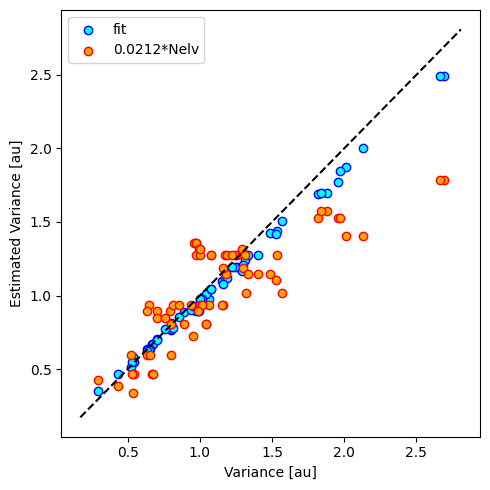

In [8]:
df = pd.read_csv('results_dim.csv', index_col=0)

# Read mol_info
with open( 'dim_info.pkl', 'rb' ) as f:
    dim_info = pickle.load( f )


df = df.loc[ (df.tau==0.01) & (df.dmc_type=='DMCdla5') ]
df.index = df.ID
df = pd.DataFrame( df['Var[au]'] )
for atom in dim_info[1]['atoms']:
    df[atom] = 0
df['Nelv'] = 0
for i in df.index:
    #print(i, dim_info[i]['atoms'])
    for atom in dim_info[i]['atoms']:
        df.loc[i,atom] = dim_info[i]['atoms'][atom]
        df.loc[i,'Nelv'] = dim_info[i]['Nelv']

y = df['Var[au]'].to_numpy()
X = [ df[i].to_numpy() for i in ['H','C','N','O']]

yhat = func(X, *popt)
yhat

df['fit'] = yhat

residual = (y-yhat)
SSR = residual.transpose().dot(residual)
print('SSR =',SSR)

# Fit with variance per electron
df['fit_Nelv'] = VAR_per_el * df['Nelv']


# Plot 
fig, ax = plt.subplots( figsize=(5,5) )
ax.scatter(y,yhat,marker='o',c='cyan',edgecolors='blue',label='fit')
ax.scatter(y,df.fit_Nelv.to_numpy(),marker='o',c='orange',edgecolors='r',label='0.0212*Nelv')
ax.set_xlabel('Variance [au]')
ax.set_ylabel('Estimated Variance [au]')

xmin, xmax = plt.xlim()
print(xmin,xmax)
xv = np.linspace(xmin,xmax,10)
ax.plot(xv,xv,'--k')

#df = df.sort_values('Var[au]')
n = list( df.index )
xn = list( df['Var[au]'] )
yn = list( df.fit )
#for i in range(len(xn)):
#    ax.annotate(n[i],(xn[i],yn[i]),
#                xytext=(xn[i]-(i%2-0.2)*0.2,yn[i]+(i%2-0.6)*0.2),
#                arrowprops=dict(facecolor='black', arrowstyle="->"))
ax.legend()
fig.tight_layout()
fig.savefig(f'FIG02c/Evaluation_Variance_dimers.png',format='png',dpi=300)

df